<a href="https://colab.research.google.com/github/clarissarusso/DS1002/blob/main/CR_%2B_PB_12_CAPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Capital Asset Pricing Model (CAPM)

### Assignment due Monday 22 April at noon

---

### Objectives

This assignment is primarily meant to refresh your numpy and pandas skills.  
Technical objectives are discussed below.  

- All the usual rules apply:  you may work together (groups of at most 3), make sure all names are easy to find at the top of the submission, submit the link to your working colab notebook


### Background

In finance, CAPM is a single-factor regression model used for analyzing (and predicting) excess stock returns. There are better, more accurate models, but it has its uses. For example, the *market beta* is a useful output which has something to do with the risk of particular investments.

1.  Read [this brief synopsis](https://en.wikipedia.org/wiki/Capital_asset_pricing_model) of CAPM.


Don't worry if you don't understand all the terminology.
Look for a moment at the main formula (in the "Formula" section).  For us that formula will look like this:

\begin{aligned}
E(R_A) = R_f + \beta_A (E(R_{SP}) - R_f)
\end{aligned}

Some notes on the symbols in this formula:
- The formula is used to estimate $E(R_A)$.  The $E$ here stands for the expected value, and $R_A$ is the rate of return of the investment $A$.
- To use this formula, you therefore need to know the values of the other variables.
- The variable $R_f$ is the "risk-free rate," which is the amount of return you can get on an investment that has zero risk, like say a bank account.
This quantity changes over time but for our purposes we can treat it as a constant.  It is hard-coded into the code below.  Make sure you see where this variable occurs in the formula above.
- In this assignment the variable $R_{SP}$ is a measure of the rate of return of the overall market.  (The $E$ on the right side also means expected value.)
- The variable $\beta_A$ measures something about the relative risk of the investment A, relative to the overall market.  The technical objective of this assignment will be to compute $\beta_A$ below, and then to examine how sensitive it is to the specific data.
- The value you get for $\beta_A$ will be a number.  If it is greater than 1, it means (*very roughly*) that the investment A is more volatile than the overall market.  If it is less than 1, it means that the investment is less volatile than the overall market.  But **do not take this too seriously!** In particular see all the caveats at the wikipedia page.
- The A investment in our example is an individual stock (Apple).



2.  Load the packages and data.  (Note that the following code chunk also hard-codes the constant $R_f$.)  
The data lives in the file `capm_market_data` in the `data` folder on the `GitHub` site.

In [12]:
# load numpy and pandas packages
import pandas as pd
import numpy as np

# get data
data = pd.read_csv('capm_market_data.csv')

# risk-free Treasury rate
R_f = 0.0175 / 252

3.  Look at some records.  
SPY is something that mirrors the S&P 500 ("the market").  
AAPL is the code for Apple stock.  
The values are closing prices, adjusted for splits and dividends.

In [13]:
data.info()
data #printing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            135 non-null    object 
 1   spy_adj_close   135 non-null    float64
 2   aapl_adj_close  135 non-null    float64
dtypes: float64(2), object(1)
memory usage: 3.3+ KB


,date,spy_adj_close,aapl_adj_close
0,2020-01-02,321.555786,298.829956
1,2020-01-03,319.120911,295.924713
2,2020-01-06,320.338379,298.282715
3,2020-01-07,319.437653,296.879883
4,2020-01-08,321.140106,301.655548
...,...,...,...
130,2020-07-09,314.380005,383.010010
131,2020-07-10,317.589996,383.679993
132,2020-07-13,314.839996,381.910004
133,2020-07-14,318.920013,388.230011


*4*.  Drop the date column

In [14]:
data_cleaned = data.drop(columns=['date']) #dropping the date column
data_cleaned.head(5) #reprinting data after column is dropped

,spy_adj_close,aapl_adj_close
0,321.555786,298.829956
1,319.120911,295.924713
2,320.338379,298.282715
3,319.437653,296.879883
4,321.140106,301.655548


5.  Compute daily returns (percentage changes in price) for both SPY and AAPL.
(Be sure to drop the first row of NaN.)  
Hint: pandas has functions to easily do this.  
Print the first 5 rows of returns.


In [15]:
data_frame = pd.DataFrame(data) #creating a new variable for a data frame
data_frame.set_index('date',inplace=True) #date column becomes index
daily_returns = data_frame.pct_change() #formula to find daily returns
daily_returns.columns = ['spy_daily_return','aapl_daily_return'] #changing the name
daily_returns = daily_returns.dropna() #removing/dropping the first row of returns
data_frame_with_returns = pd.concat([data_frame, daily_returns], axis=1)
data_frame_with_returns.head(5) #printing the first 5 rows of returns

,spy_adj_close,aapl_adj_close,spy_daily_return,aapl_daily_return
date,,,,
2020-01-02,321.555786,298.829956,NaN,NaN
2020-01-03,319.120911,295.924713,-0.007572,-0.009722
2020-01-06,320.338379,298.282715,0.003815,0.007968
2020-01-07,319.437653,296.879883,-0.002812,-0.004703
2020-01-08,321.140106,301.655548,0.005330,0.016086


*6*.  Save the SPY and AAPL returns into separate numpy arrays.  
Print the first five values from each of the two arrays.


In [18]:
#Save the SPY and AAPL returns into separate numpy arrays.
return_spy = daily_returns['spy_daily_return'].values
return_aapl = daily_returns['aapl_daily_return'].values

#Print the first five values from each of the two arrays
print(return_spy[:5])
print(return_aapl[:5])

[-0.00757217  0.00381507 -0.0028118   0.00532953  0.00678059]
[-0.00972206  0.00796825 -0.00470303  0.01608619  0.02124092]


7.  Make arrays (one for SPY, one for AAPL) containing the *excess* returns by subtracting the constant $R_f$ from the returns.  
(Recall that $R_f$ is the "risk-free rate" meaning essentially that you could earn this much in interest if you didn't invest in anything.)  
Print the LAST five excess returns from both SPY and AAPL numpy arrays.

In [21]:
return_spy_excess = return_spy - R_f
return_aapl_excess = return_aapl - R_f
#^making arrays and calculatig the excess returns with new variables
print("SPY excess returns:", return_spy_excess[-5:])
print("AAPL excess returns:", return_aapl_excess[-5:])

SPY excess returns: [-0.00576237  0.0101411  -0.00872841  0.01288957  0.00911779]
AAPL excess returns: [ 0.00423088  0.00167981 -0.00468264  0.01647898  0.00680788]


8. Make a scatterplot with SPY excess returns on the $x$-axis and AAPL excess returns on the $y$-axis.  
If you need it, here is the [Matplotlib documentation]( https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html).

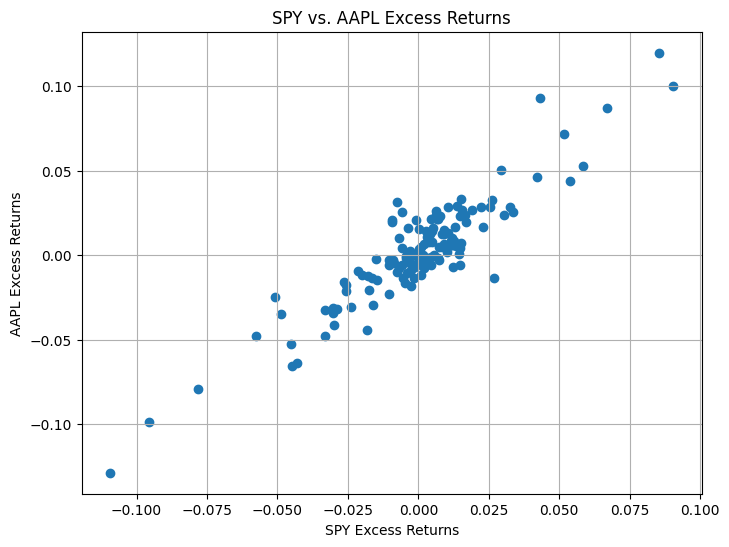

In [23]:
import matplotlib.pyplot as plt

#Make a scatterplot with titles and labeled axes
plt.figure(figsize=(8,6))
plt.scatter(return_spy_excess, return_aapl_excess)
plt.xlabel('SPY Excess Returns')
plt.ylabel('AAPL Excess Returns')
plt.title('SPY vs. AAPL Excess Returns')
plt.grid(True)
plt.show() #printing / showing plot

The value of $\beta_A$ is computed from the arrays you built in problem 7, via a formula that uses some statistical functions called the "variance" and the "covariance."

Any individual 1-d array of numbers has a variance, which you can compute using `numpy`'s function `var()` (documented [here](https://numpy.org/doc/stable/reference/generated/numpy.var.html)).  This is a number.

If you have two 1-d arrays of the same length, they collectively have something called a covariance which `numpy` also can compute using `cov()` (documented [here](https://numpy.org/doc/stable/reference/generated/numpy.cov.html)).

The covariance is also a number, but look at what happens when you send two 1-d arrays to `cov()`: it returns a $2\times 2$ matrix.  (Try it!)  The covariance we are looking for is the number that lives in both the top right and the bottom left of this matrix.  (Those two numbers should be the same.)  The top left and bottom right entries of the covariance matrix also have meaning, but we don't need them.



9. Use `numpy` functions as described above to compute the estimate of $\beta_A$, using the following formula:  
\begin{aligned} \beta_A= \frac{ \text{cov}(A,SP) }{ \text{var}(SP) } \end{aligned}
In our context, A will be the 1-d array you made in problem 7 for AAPL, and SP will be the 1-d array you made for SPY.

In [30]:
matrix_covariance = np.cov(return_aapl_excess, return_spy_excess)
cov_sa = matrix_covariance[0,1] #covariance between excess returns
varation_spy = np.var(return_spy_excess)
beta_a = cov_sa / varation_spy
print("𝛽𝐴 estimate:", beta_a)

𝛽𝐴 estimate: 1.0956172644197222


You should have found that the beta estimate is greater than one.  
This means that the volatility of AAPL stock, given the data, and according to this particular (flawed) model,
is higher than the volatility of the S&P 500.

Bonus:  Is this something you can see on the plot you made?



Finally, let's look at how sensitive the beta is to each data point.   
We want to drop each data point (one at a time), compute \\(\hat\beta_i\\) using our formula from above, and save each measurement.

This is called *jackknifing*.



10. Write a function called `beta_sensitivity()` with these specs:

- take numpy arrays `x` and `y` as inputs
- outputs a list of tuples, so that each tuple contains (observation row dropped, beta estimate)

Hint: **np.delete(x, i).reshape(-1,1)** will delete observation i from array x, and make it a column vector

In [33]:
import numpy as np

def beta_sensitivity(x, y):
  sensitivity = []
  n = len(x)
  beta_all = np.cov(x, y)[0, 1] / np.var(x) #use provided data points
  for i in range(n):
      x_temp = np.delete(x, i)
      y_temp = np.delete(y, i)
      beta_temp = np.cov(x_temp, y_temp)[0, 1] / np.var(x_temp)
      sensitivity.append((i, beta_temp))

  return sensitivity

11. Call `beta_sensitivity()` on the arrays A and SP from earlier and print the first ten tuples of output.

In [34]:
sensitivity_measurements = beta_sensitivity(return_spy, return_aapl)
print(sensitivity_measurements[:10])

[(0, 1.095384550080496), (1, 1.095618983478552), (2, 1.095555855660709), (3, 1.0952630299046584), (4, 1.0949054764016837), (5, 1.09578886233597), (6, 1.0948925461451775), (7, 1.095406013243971), (8, 1.0958504733995793), (9, 1.095567664392224)]
